# Phonological features

In [106]:
%load_ext blackcellmagic
import os
from utils import ROOT
os.chdir(ROOT)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
from models import all_trained_phoneme_models, performance
from scipy.stats import ttest_rel, spearmanr

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


## Performance of ground truth vs learnt representations

In [51]:
models = all_trained_phoneme_models()
results = []
for model in models:
    if "hidden" in model:
        ppl = performance(**model)
        model_copy = model.copy()
        model_copy["ppl"] = ppl
        results.append(model_copy)
df = pd.DataFrame(results)
uses_ground_truth = df["size"] == "groundTruth"
ground_truth = df[uses_ground_truth]
learnt = df[~uses_ground_truth]
merged = pd.merge(
    learnt,
    ground_truth,
    on=["level", "lg", "name", "hidden", "epoch"],
    how="inner",
    suffixes=("_learnt", "_true"),
)
merged["ppl_delta"] = merged["ppl_true"] - merged["ppl_learnt"]
merged["ppl_delta_percent"] = (merged["ppl_delta"] / merged["ppl_true"]) * 100
merged

,level,lg,name,size_learnt,hidden,epoch,ppl_learnt,size_true,ppl_true,ppl_delta,ppl_delta_percent
0,phoneme,cat,rnn,30,20,0,19.150223,groundTruth,19.880260,0.730038,3.672174
1,phoneme,cat,rnn,20,20,0,18.970442,groundTruth,19.880260,0.909819,4.576493
2,phoneme,cat,rnn,10,20,0,21.144991,groundTruth,19.880260,-1.264730,-6.361740
3,phoneme,cat,rnn,5,20,0,20.440744,groundTruth,19.880260,-0.560484,-2.819299
4,phoneme,cat,rnn,30,20,1,17.279394,groundTruth,18.229013,0.949619,5.209384
...,...,...,...,...,...,...,...,...,...,...,...
9541,phoneme,afr,lstm,5,50,8,12.898238,groundTruth,12.584450,-0.313788,-2.493462
9542,phoneme,afr,lstm,30,50,9,11.695046,groundTruth,12.342327,0.647281,5.244397
9543,phoneme,afr,lstm,20,50,9,11.589212,groundTruth,12.342327,0.753115,6.101886
9544,phoneme,afr,lstm,10,50,9,12.751270,groundTruth,12.342327,-0.408943,-3.313339


In [60]:
stats_by_lg = (
    merged.groupby("lg")[["ppl_true", "ppl_learnt"]]
    .apply(lambda g: ttest_rel(g["ppl_true"], g["ppl_learnt"]))
    .to_frame("stats")["stats"]
    .apply(pd.Series)
    .rename(columns={0: "t", 1: "p"})
)

In [61]:
def training_size(lg):
    filename = f"data/phoneme/wikipron/{lg}/train.txt"
    with open(filename) as file:
        contents = file.read()
    return contents.count("\n") + 1

In [97]:
stats_by_lg["n"] = stats_by_lg.index.map(training_size)
stats_by_lg

,t,p,size,n
lg,,,,
acw,-10.136076,2.261193e-22,675,675
afb,-20.009175,1.356089e-68,386,386
afr,-12.375798,3.602983e-31,1031,1031
alb,-14.279039,5.922976e-40,1064,1064
ale,-18.160415,4.820746e-59,91,91
ara,-3.389161,7.494303e-04,4554,4554
ary,-11.797164,4.991615e-29,276,276
asm,-6.086347,2.104903e-09,1971,1971
ayl,-7.239365,1.388746e-12,137,137


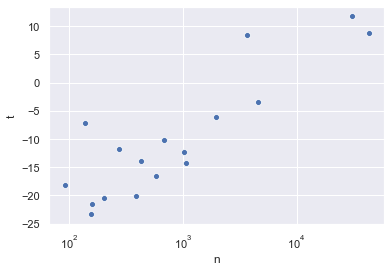

In [98]:
grid = sns.scatterplot(data=stats_by_lg, x="n", y="t")
grid.set(xscale="log");

In [68]:
stats_by_epoch = (
    merged.groupby("epoch")[["ppl_true", "ppl_learnt"]]
    .apply(lambda g: ttest_rel(g["ppl_true"], g["ppl_learnt"]))
    .to_frame("stats")["stats"]
    .apply(pd.Series)
    .rename(columns={0: "t", 1: "p"})
)
stats_by_epoch.sort_values("t")

,t,p
epoch,,
1,-14.955611,8.728011e-46
2,-14.361601,1.433285e-42
0,-13.435270,5.969416e-38
3,-13.244895,6.457060e-37
4,-12.118126,1.486094e-31
5,-11.485880,1.114367e-28
7,-10.942931,2.712287e-26
6,-10.690291,2.961941e-25
8,-10.317507,1.096505e-23


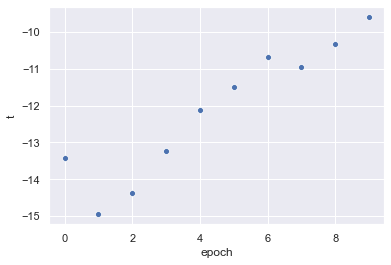

In [70]:
grid = sns.scatterplot(data=stats_by_epoch, x=stats_by_epoch.index, y="t");

## Correlation of dissimilarity

In [122]:
def read_correlation(**kwargs):
    assert "size" != "groundTruth", "This doesn't make sense for ground truth representations"
    lg, name, epoch = kwargs["lg"], kwargs["name"], kwargs["epoch"]
    if "hidden" in kwargs:
        hyperparams = f"{kwargs['size']}-{kwargs['hidden']}"
    else:
        hyperparams = f"{kwargs['size']}-{kwargs['window']}"
    filename = f"results/phoneme/correlation/{lg}/{name}/{hyperparams}/{epoch}.txt"
    with open(filename) as file:
        contents = file.read()
    r, p = eval(contents)
    return r, p

In [123]:
results = []
for model in models:
    try:
        r, p = read_correlation(**model)
        model_copy = model.copy()
        model_copy["r"], model_copy["p"] = r, p
        if "hidden" in model:
            ppl = performance(**model)
            model_copy["ppl"] = ppl
        results.append(model_copy)
    except FileNotFoundError:
        continue
df = pd.DataFrame(results)
df["n"] = df["lg"].apply(training_size)
df["size"] = df["size"].astype(int)
df

,level,lg,name,size,hidden,epoch,r,p,ppl,window,n
0,phoneme,cat,gru,10,10,0,0.583714,1.945843e-33,17.290003,NaN,43200
1,phoneme,cat,gru,10,10,1,0.583714,1.945843e-33,16.192991,NaN,43200
2,phoneme,cat,gru,10,10,2,0.583714,1.945843e-33,15.326177,NaN,43200
3,phoneme,cat,gru,10,10,3,0.583714,1.945843e-33,14.832352,NaN,43200
4,phoneme,cat,gru,10,10,4,0.583714,1.945843e-33,14.583613,NaN,43200
...,...,...,...,...,...,...,...,...,...,...,...
10843,phoneme,ind,word2vec,5,NaN,3,-0.068493,1.683713e-01,NaN,2.0,1155
10844,phoneme,ind,word2vec,5,NaN,2,-0.068493,1.683713e-01,NaN,2.0,1155
10845,phoneme,ind,word2vec,5,NaN,1,-0.068493,1.683713e-01,NaN,2.0,1155
10846,phoneme,ind,word2vec,20,NaN,10,-0.113470,2.221378e-02,NaN,1.0,1155


In [114]:
df.groupby("n").apply(lambda g: spearmanr(g["r"], g["ppl"])[0])

n
91      -0.371513
137     -0.194160
154     -0.244237
158     -0.333660
174     -0.352455
204     -0.373570
276     -0.077379
386     -0.402462
431     -0.403378
582     -0.192688
675     -0.006916
1064    -0.020135
1971     0.109166
3663    -0.099096
4554    -0.131560
8650          NaN
43200    0.291142
dtype: float64

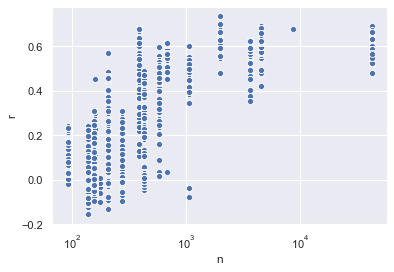

In [117]:
grid = sns.scatterplot(data=df, x="n", y="r")
grid.set(xscale="log");